## **Telecom Churn Prediction**



### Libraries

In [24]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn -q

### Import the libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score
)

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### LOAD DATA

In [26]:
df = pd.read_csv("telecom_churn.csv")

print("Dataset shape:", df.shape)

Dataset shape: (243553, 14)


### BASIC CLEANING

In [27]:
# Convert date column
df["date_of_registration"] = pd.to_datetime(df["date_of_registration"])

# Create tenure feature (days since registration)
df["tenure_days"] = (
    df["date_of_registration"].max() - df["date_of_registration"]
).dt.days

# Drop original date column
df.drop(columns=["date_of_registration"], inplace=True)

# Fix negative data_used values (domain correction)
df["data_used"] = df["data_used"].abs()

### FEATURE & TARGET SPLIT

In [28]:
X = df.drop(columns=["customer_id", "churn"])
y = df["churn"]

### ENCODE CATEGORICAL FEATURES

In [29]:
categorical_cols = X.select_dtypes(include="object").columns

encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

print("Final feature shape:", X.shape)

Final feature shape: (243553, 12)


### HANDLE CLASS IMBALANCE (SMOTE)

In [30]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("Balanced class distribution:", np.bincount(y_balanced))

Balanced class distribution: [194726 194726]


### TRAIN-TEST SPLIT

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

### BASELINE MODEL – LOGISTIC REGRESSION

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("\nLOGISTIC REGRESSION (BASELINE)")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


LOGISTIC REGRESSION (BASELINE)
Accuracy: 0.5362750510328536
ROC-AUC: 0.5645819698523287


### MAIN MODEL – RANDOM FOREST

In [33]:
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\nRANDOM FOREST (FINAL MODEL)")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


RANDOM FOREST (FINAL MODEL)
Accuracy: 0.8461568088739392
ROC-AUC: 0.8723099456399586
F1 Score: 0.8197963817916598

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.99      0.87     38946
           1       0.99      0.70      0.82     38945

    accuracy                           0.85     77891
   macro avg       0.88      0.85      0.84     77891
weighted avg       0.88      0.85      0.84     77891



###  CONFUSION MATRIX

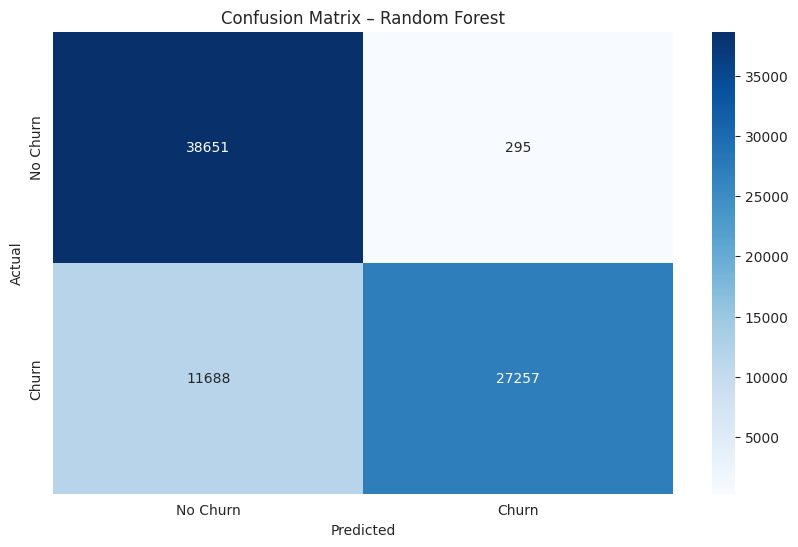

In [34]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC CURVE

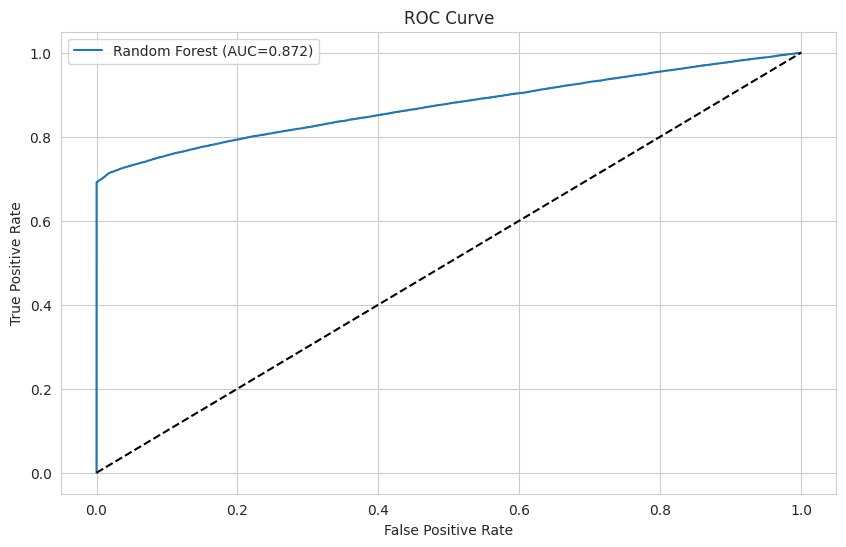

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)

plt.plot(
    fpr,
    tpr,
    label=f"Random Forest (AUC={roc_auc_score(y_test, y_proba_rf):.3f})"
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### FEATURE IMPORTANCE


Top 10 Important Features:
            Feature  Importance
1            gender    0.322130
0   telecom_partner    0.305715
4              city    0.149507
6    num_dependents    0.048097
3             state    0.046297
11      tenure_days    0.024167
2               age    0.023667
8        calls_made    0.019551
9          sms_sent    0.018473
10        data_used    0.014220


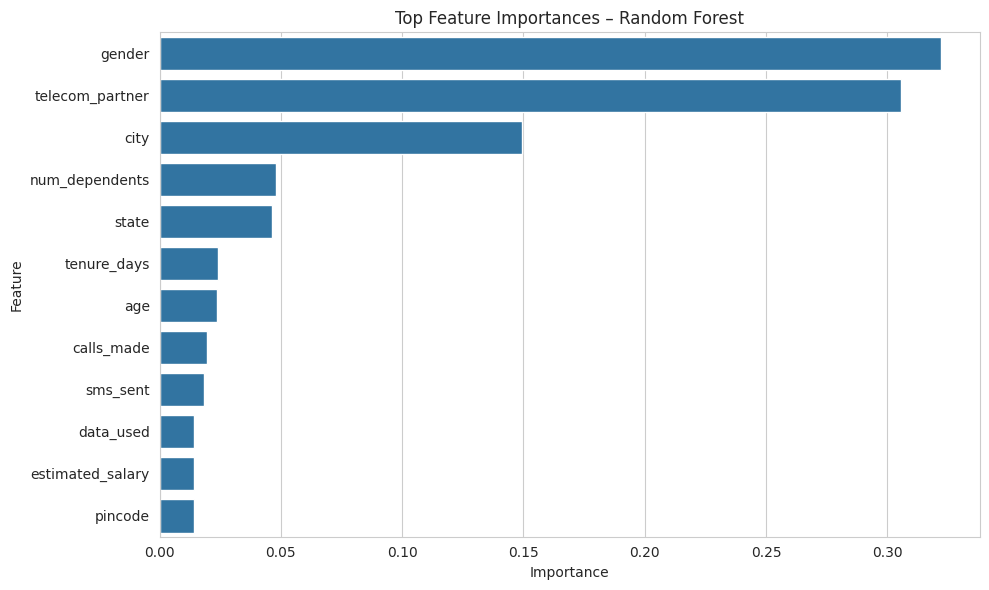

In [36]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df.head(15),
    x="Importance",
    y="Feature"
)
plt.title("Top Feature Importances – Random Forest")
plt.tight_layout()
plt.show()